In [1]:
import sys         
sys.path.append('./../src/') 
import pandas as pd
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from data.load_data import load_ptbxl_data
from signals.ecg import ECGSignal
from biosppy.signals.ecg import ecg

TARGET = 'diagnostic_class'
DATASET_PATH = Path("./../data/ptbxl")

%load_ext autoreload
%autoreload 2

In [2]:
ptbxl_data = load_ptbxl_data(
    sampling_rate=100,
    path = DATASET_PATH,
    target = TARGET
)

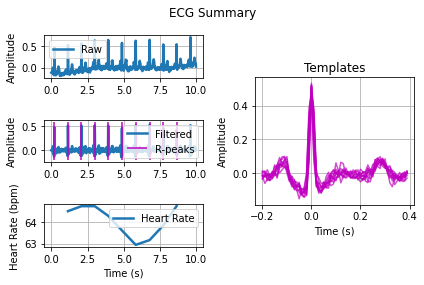

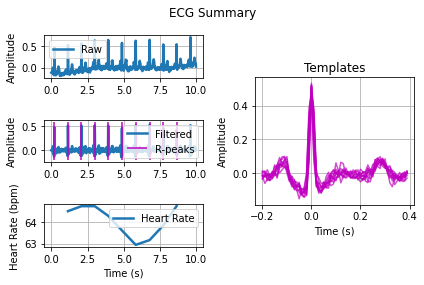

In [3]:
ecg_data = ptbxl_data['train']['X'][0, :, 0]
ecg_sig = ECGSignal("ECG", ecg_data, 100)
ecg_info = ecg(ecg_data, 100)

In [24]:
from signals.utils import parse_nested_feats
import pandas as pd
from tqdm.auto import tqdm

In [21]:
nested_feats = ecg_sig.extract_features()
feats = parse_nested_feats(nested_feats)

In [71]:
from joblib import Parallel, delayed

def get_feats_for_all_channels(ecg_data):
    try:
        feats = {}
        for i, ecg_channel in enumerate(ecg_data.T):
            ecg_channel_sig = ECGSignal(f"ecg_{i}", ecg_channel, 100)
            feats[ecg_channel_sig.name] = ecg_channel_sig.extract_features()
        feats = parse_nested_feats(feats)
        return feats
    except Exception:
        return None

dfs = {}

for split_name, split in ptbxl_data.items():
    X = split['X']
    rows = np.array(Parallel(n_jobs=-1)(delayed(get_feats_for_all_channels)(ecg_data) for ecg_data in tqdm(X)))
    valid_rows = np.array([row is not None for row in rows])
    dfs[split_name] = {
        'X': pd.DataFrame(list(rows[valid_rows])),
        'y': ptbxl_data[split_name]['y'].values[valid_rows]
    }

  0%|          | 0/12978 [00:00<?, ?it/s]

  0%|          | 0/1642 [00:00<?, ?it/s]

  0%|          | 0/1652 [00:00<?, ?it/s]

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, auc, roc_auc_score
from sklearn.preprocessing import LabelEncoder

def get_metrics(y_true, y_pred):
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'fscore': f1_score(y_true, y_pred, average='macro'),
        # 'roc_auc': roc_auc_score(y_true, y_pred, multi_class='ovo')
    }

In [93]:
# model = RandomForestClassifier()

# X_train = dfs['train']['X']
# y_train = dfs['train']['y']

# X_val = dfs['val']['X']
# y_val = dfs['val']['y']

# X_test = dfs['test']['X']
# y_test = dfs['test']['y']

# le = LabelEncoder()
# le.fit(y_train)

# y_train = le.transform(y_train)
# y_val = le.transform(y_val)
# y_test = le.transform(y_test)

# model.fit(X_train, y_train)

# y_pred_train = model.predict(X_train)
# y_pred_val = model.predict(X_val)
# y_pred_test = model.predict(X_test)

train_metrics = get_metrics(y_train, y_pred_train)
val_metrics = get_metrics(y_val, y_pred_val)
test_metrics = get_metrics(y_test, y_pred_test)

print(f"Train:\n {train_metrics}\n\nVal:\n {val_metrics}\n\nTest:\n {test_metrics}")

Train:
 {'accuracy': 0.9999229287090559, 'fscore': 0.9998986802870299}

Val:
 {'accuracy': 0.7081048141377209, 'fscore': 0.5518383787640784}

Test:
 {'accuracy': 0.6943099273607748, 'fscore': 0.5251390280831866}


In [85]:
np.unique(y_train)

array([0, 1, 2, 3, 4])

In [42]:
X.shape

(12978, 1000, 12)

In [36]:
ptbxl_data['train']['y'].unique()

array(['NORM', 'STTC', 'CD', 'HYP', 'MI'], dtype=object)

In [33]:
ptbxl_data['train']['X'].shape

(12978, 1000, 12)